In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.preprocessing import normalize
np.random.seed(0x5eed)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
num_bins = 10
num_classes = 27

In [14]:
df = pd.read_csv("data/jamia/hgru_128_results_for_calibration.csv", sep=',') 

(array([30747.,   627.,  2540.,  1864.,   587.,   341.,  2571.,   186.,
          558.,  8575.,  1987.,  1546.,  3203.,  3141.,  1977.,  3385.,
          170.,  1163.,  1695.,  2263.,  6622.,  3543.,  5316.,  2778.,
          396.,  1879., 15288.]),
 array([ 0.        ,  0.96296296,  1.92592593,  2.88888889,  3.85185185,
         4.81481481,  5.77777778,  6.74074074,  7.7037037 ,  8.66666667,
         9.62962963, 10.59259259, 11.55555556, 12.51851852, 13.48148148,
        14.44444444, 15.40740741, 16.37037037, 17.33333333, 18.2962963 ,
        19.25925926, 20.22222222, 21.18518519, 22.14814815, 23.11111111,
        24.07407407, 25.03703704, 26.        ]),
 <a list of 27 Patch objects>)

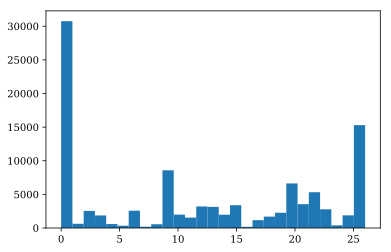

In [18]:
plt.hist(df['Correct'],bins = num_classes)

In [20]:
def EceEval(confidence, y, num_bins=10):
    bins = np.linspace(0, 1, num_bins+1)
    digitized = np.digitize(confidence, bins[1:-1])
    
    w = np.array([(digitized==i).sum() for i in range(num_bins)])
    w = w/sum(w)

    confidence_bins = np.array([confidence[digitized==i].mean() for i in range(num_bins)])
    accuracy_bins = np.array([y[digitized==i].mean() for i in range(num_bins)])
    confidence_bins[np.isnan(confidence_bins)] = 0
    accuracy_bins[np.isnan(accuracy_bins)] = 0
    diff = np.absolute(confidence_bins - accuracy_bins)
    ece = np.inner(diff,w)
    return ece

In [22]:
column_names = ['Predicted_Class_k', 'R_k', 'N_k','Acc_k', 'Conf_k', 'ECE_k', 'Calibration_Bias_k']
output_df = pd.DataFrame(np.zeros((num_classes,len(column_names))), columns = column_names) 

output_df['Predicted_Class_k'] = [id for id in range(num_classes)]
output_df['R_k'] = [df[(df['Correct']==id) & (df['Predicted']==id)].shape[0] for id in range(num_classes)]
output_df['N_k'] = [df[(df['Predicted']==id)].shape[0] for id in range(num_classes)]
output_df['Acc_k'] = output_df['R_k'] / output_df['N_k']
output_df['Conf_k'] = [df[(df['Predicted']==id)]['Confidence'].mean() for id in range(num_classes)]
output_df['Calibration_Bias_k'] = output_df['Conf_k'] - output_df['Acc_k']
for class_idx in range(num_classes):
    mask = (df['Predicted']==class_idx)
    confidence = df[mask]['Confidence']
    y = df[mask]['Correct'] == df[mask]['Predicted']
    output_df['ECE_k'][class_idx] = EceEval(confidence, y, num_bins=num_bins)
output_df.to_csv('jamia_hgru_128_output_df.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


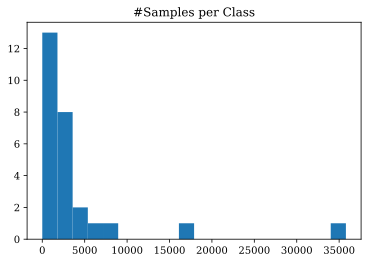

<Figure size 432x288 with 0 Axes>

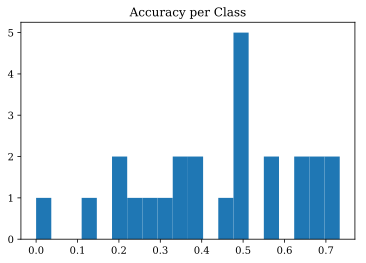

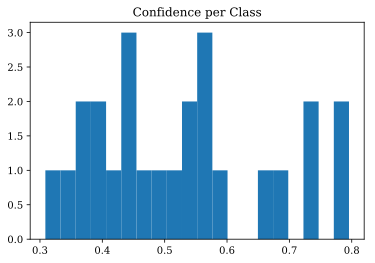

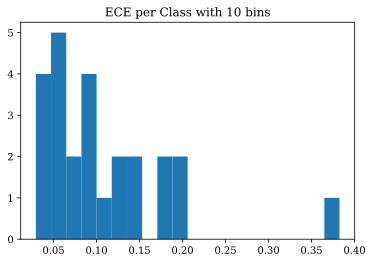

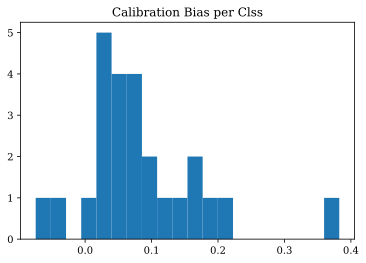

In [23]:
plt.figure();
plt.hist(output_df['N_k'],bins=20);
plt.title('#Samples per Class');
plt.figure();
plt.figure();
plt.hist(output_df['Acc_k'],bins=20);
plt.title('Accuracy per Class');
plt.figure();
plt.hist(output_df['Conf_k'],bins=20);
plt.title('Confidence per Class');
plt.figure();
plt.hist(output_df['ECE_k'],bins=20);
plt.title('ECE per Class with %d bins' % num_bins);
plt.figure();
plt.hist(output_df['Calibration_Bias_k'],bins=20);
plt.title('Calibration Bias per Clss');

In [24]:
# class with loweest accuracy
output_df.sort_values('Acc_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
7,7,0,15,0.000000,0.382504,0.382504,0.382504
8,8,13,97,0.134021,0.308658,0.174637,0.174637
18,18,317,1538,0.206112,0.405465,0.199353,0.199353
19,19,217,1013,0.214215,0.337346,0.123131,0.123131
14,14,277,1200,0.230833,0.432024,0.201190,0.201190
1,1,123,453,0.271523,0.444353,0.172830,0.172830
11,11,288,886,0.325056,0.375209,0.085387,0.050153
17,17,165,488,0.338115,0.358287,0.117769,0.020172
5,5,20,59,0.338983,0.419252,0.144354,0.080269
12,12,924,2444,0.378069,0.467551,0.094606,0.089482


In [25]:
# class with loweest calibration bias
output_df.sort_values('Calibration_Bias_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
4,4,212,378,0.560847,0.486436,0.102518,-0.074411
13,13,1451,3070,0.472638,0.442008,0.053753,-0.030630
22,22,2911,4305,0.676190,0.693049,0.029471,0.016859
6,6,2207,3092,0.713777,0.731924,0.037031,0.018146
17,17,165,488,0.338115,0.358287,0.117769,0.020172
3,3,1104,1939,0.569366,0.589934,0.049647,0.020568
20,20,4210,6615,0.636432,0.660119,0.043147,0.023687
15,15,1610,3265,0.493109,0.531533,0.041994,0.038424
11,11,288,886,0.325056,0.375209,0.085387,0.050153
2,2,1336,2697,0.495365,0.548244,0.055311,0.052879


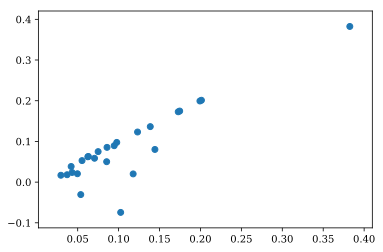

In [26]:
plt.scatter(output_df['ECE_k'], output_df['Calibration_Bias_k'])